# Fundamentals of Deep Learning

In [35]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False); 

In [36]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.16.1'

In [37]:
%matplotlib inline

## **Long Short Term Memory RNN (LSTM)**

Los módulos repetitivos RNN simples tienen una estructura básica con una sola capa tanh. La estructura simple de RNN adolece de poca memoria, donde tiene dificultades para retener información de pasos de tiempo anteriores en datos secuenciales más grandes. Estos problemas pueden resolverse fácilmente mediante la memoria a largo plazo (LSTM) y la unidad recurrente cerrada (GRU), ya que son capaces de recordar largos períodos de información.


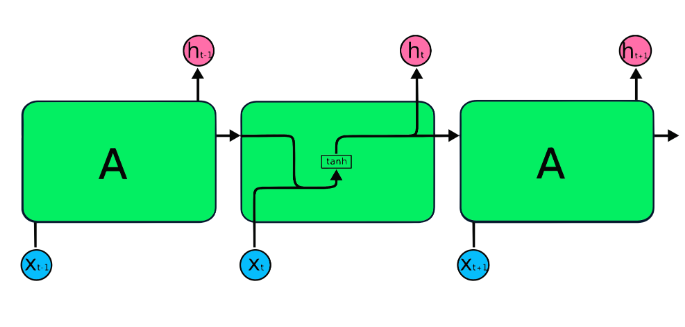

In [38]:
from IPython.display import Image
Image(filename = 'local/imgs/rnn_advanced_arquitectures.png')

El principal inconveniente de los RNN convencionales es su incapacidad para aprender la dependencia a largo plazo, o incluso la capacidad de capturar dependencias largas y cortas al mismo tiempo.

Recuerda que en un RNN:

$${\bf{a}}^{(t)} = {\bf{b}} + {\bf{V}}{\bf{h}}^{(t-1)} + {\bf{U}}{\bf{x}}^{(t)},\\ {\bf{h}}^{(t)} = \tanh({\bf{a}}^{(t)}), \\ {\bf{o}}^{(t)} = {\bf{c}} + {\bf{W}}{\bf{h}}^{(t)}$$

y,

$$ \nabla_{{\bf{h}}^{(t)}}L = {\bf{V}}^T\text{diag} \left( 1 - \left( {\bf{h}}^{(t+1)} \right)^2\right)(\nabla_{{\bf{h}}^{(t+1)}} L) + {\bf{W}}^T(\nabla_{{\bf{o}}^{(t)}}L)$$

y,

$$\nabla_{\bf V}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)(\nabla_{{\bf{h}}^{(t)}} L){\bf{h}}^{(t-1)^T}$$

Por lo tanto, durante la fase de entrenamiento de una serie de tiempo, la matriz $\bf{V}$, que contiene los pesos del ciclo de retroalimentación, se multiplica por sí misma $(\tau-1)$ veces. Así, si sus valores son cercanos a cero, los pesos acaban desapareciendo. Por el contrario, si los pesos de $\bf{V}$ son demasiado grandes, terminan divergiendo (en caso de que no se incluya ningún método de regularización). Este hecho hace que los RNN convencionales sean muy inestables.

También son muy sensibles al fenómeno de gradientes que desaparecen, pero esto se puede superar utilizando las funciones de activación Relu o LeakyRelu.

**LSTM** son un tipo de RNN propuestos para abordar los problemas anteriores. Se introdujeron en 1997 y se basan en diferentes tipos de unidad básica llamada **célula**.

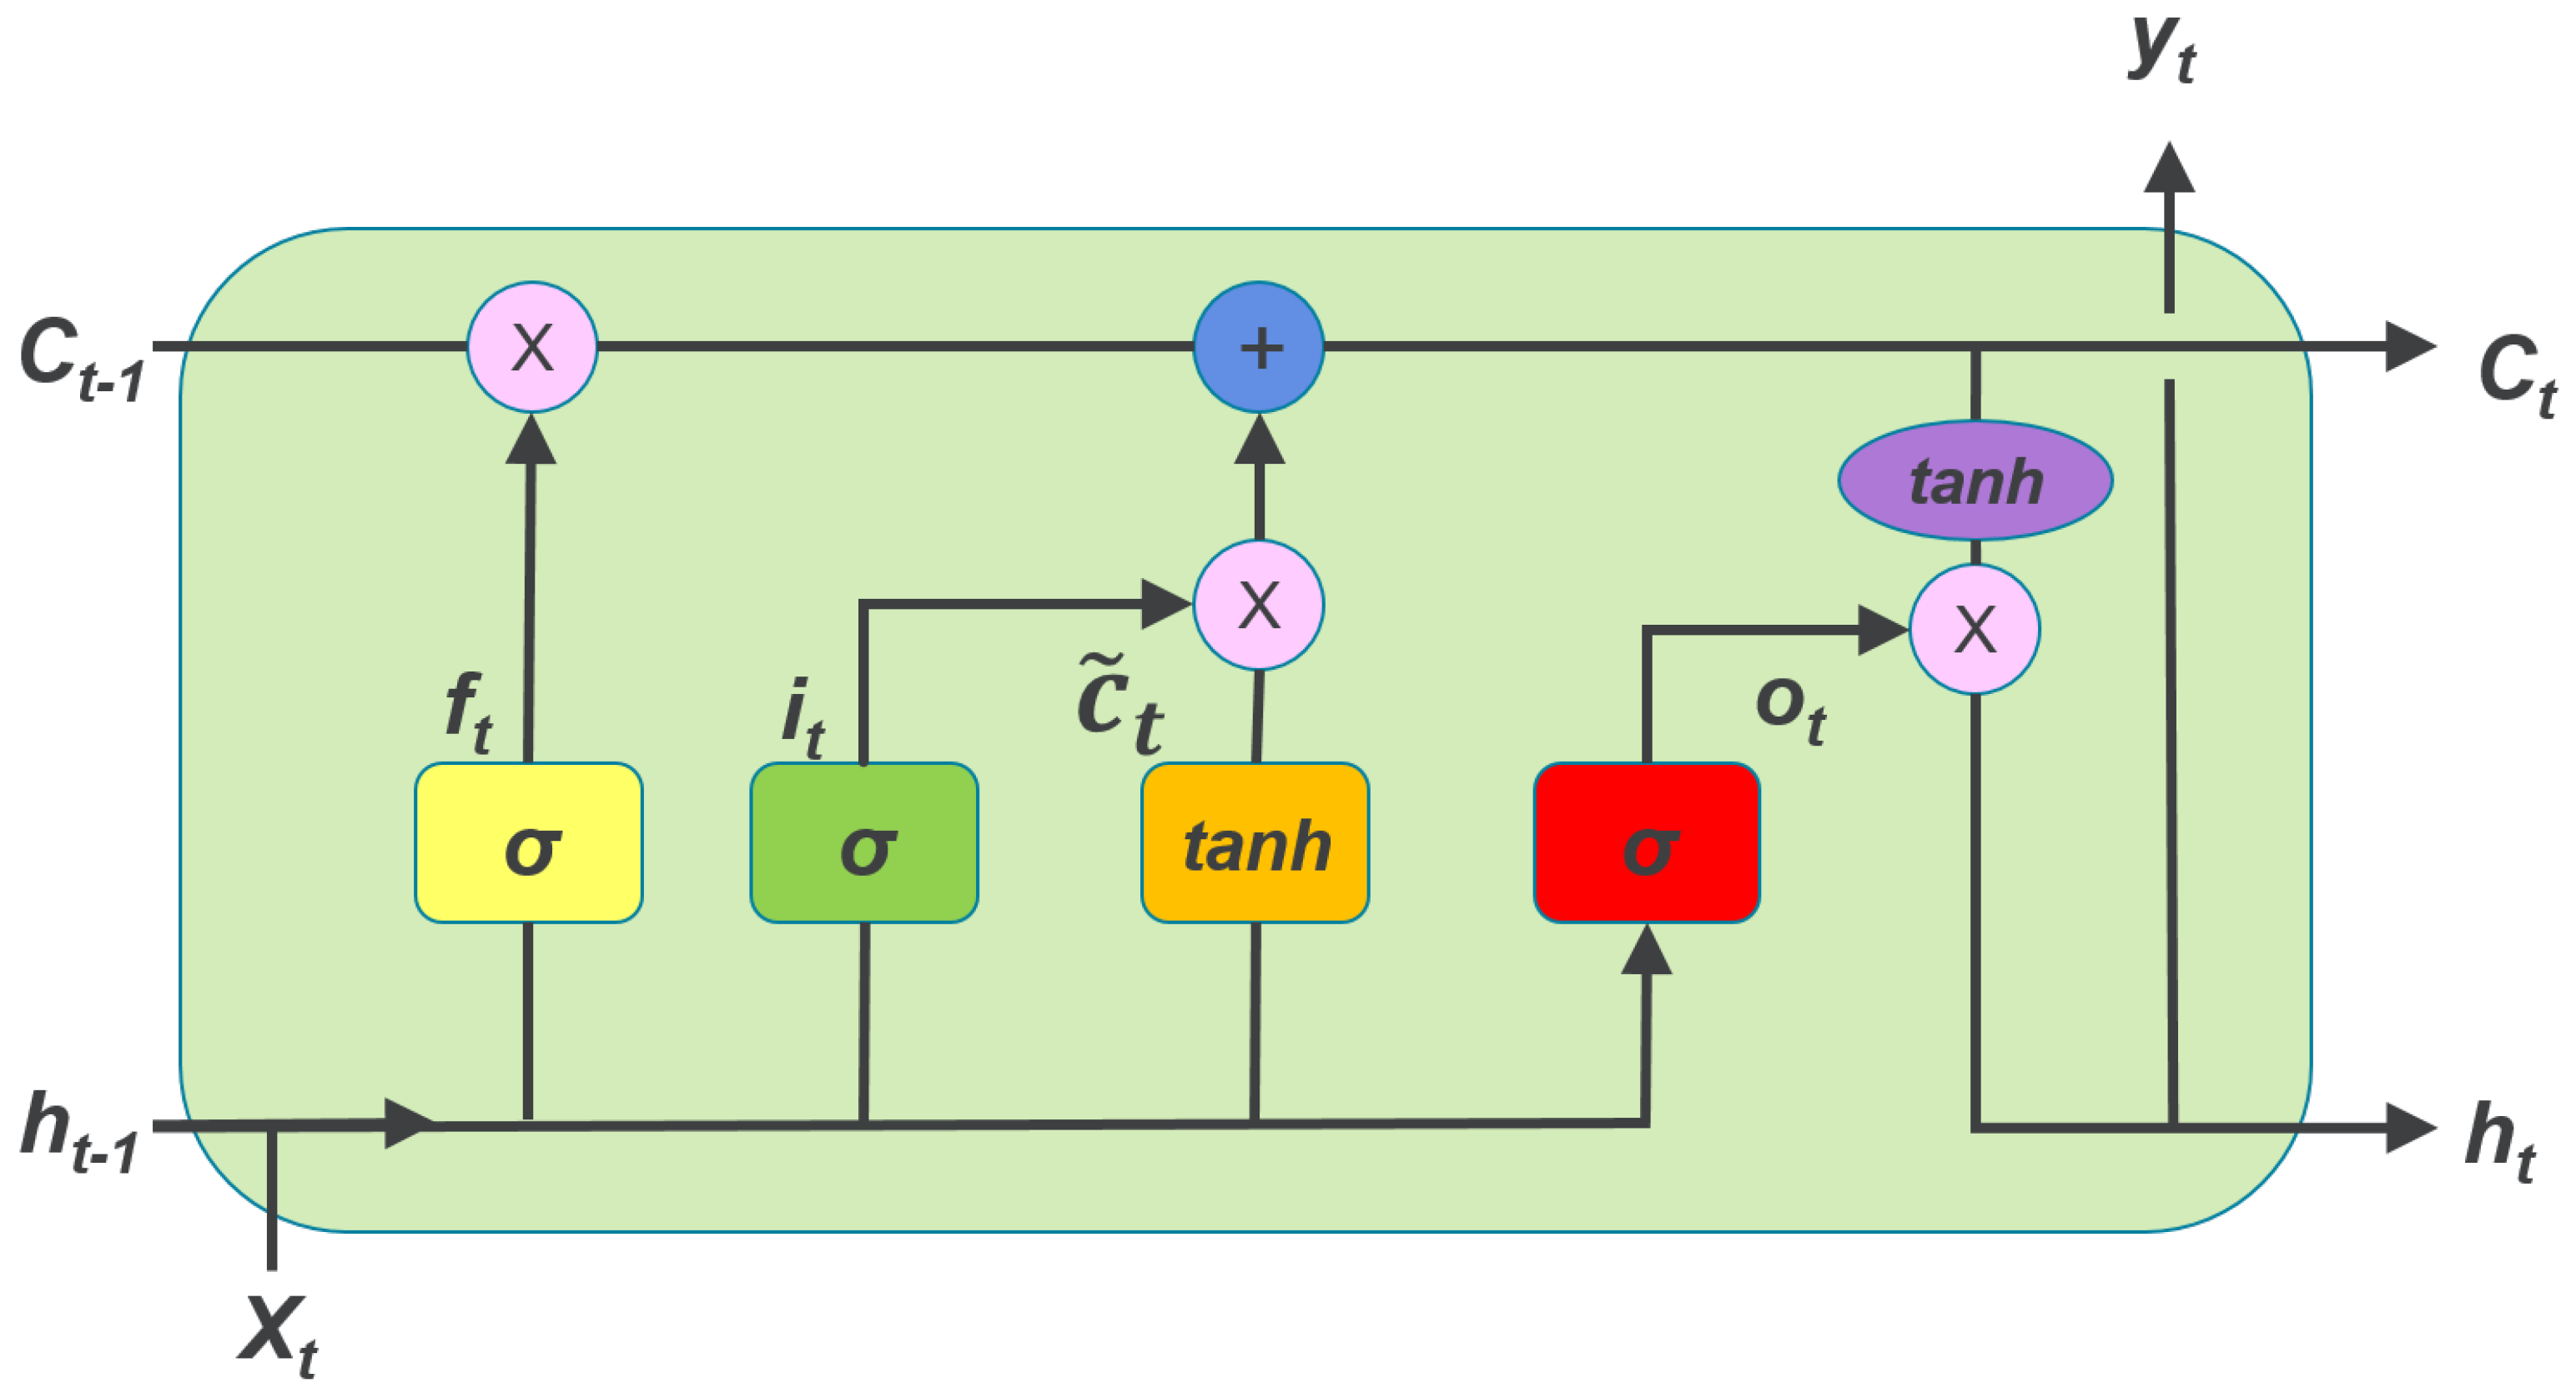

In [39]:
from IPython.display import Image
Image(filename='local/imgs/LSTM2.png', width=1200)

Las celdas utilizan el principio de promedio acumulativo llamado **Promedio móvil ponderado exponencial (EWMA)** propuesto originalmente para un tipo de unidades llamadas unidades con fugas. EWMA tiene en cuenta más o menos información del pasado basándose en un parámetro $\beta$. La regla viene dada por: $\mu^{(t)} \leftarrow \beta \mu^{(t-1)} + (1 - \beta)\upsilon^{(t)}$.

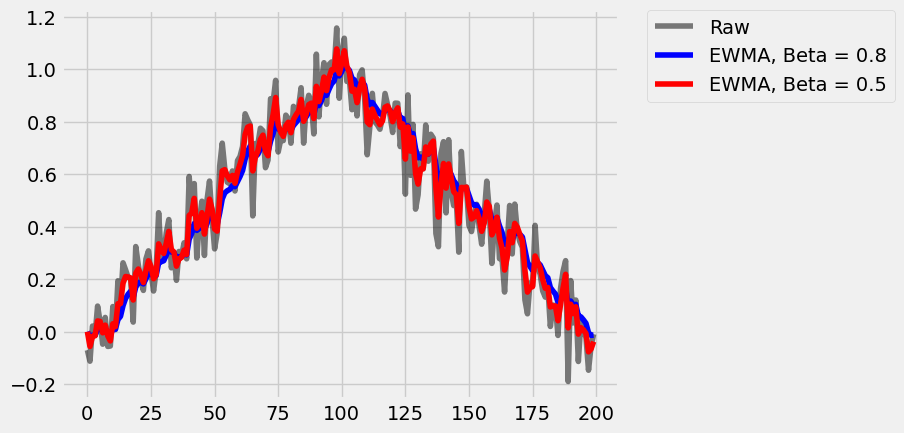

In [40]:
import numpy as np
import matplotlib.pyplot as plt 
# make a hat function, and add noise
x = np.linspace(0,1,100)
x = np.hstack((x,x[::-1]))
x += np.random.normal( loc=0, scale=0.1, size=200 )
plt.plot( x, 'k', alpha=0.5, label='Raw' )
 
Beta1 = 0.8
Beta2 = 0.5
x1 = np.zeros(200)
x2 = np.copy(x1)
for i in range(1,200):
    x1[i] = Beta1*x1[i-1] + (1-Beta1)*x[i]
    x2[i] = Beta2*x2[i-1] + (1-Beta2)*x[i]
# regular EWMA, with bias against trend
plt.plot( x1, 'b', label='EWMA, Beta = 0.8' )
 
# "corrected" (?) EWMA
plt.plot( x2, 'r', label='EWMA, Beta = 0.5' )
 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#savefig( 'ewma_correction.png', fmt='png', dpi=100 )

La red LSTM utiliza el mismo principio de nivel de memoria o dependencia del tiempo, pero en lugar de un parámetro de control, define **puertas** ajustadas durante la fase de entrenamiento.

Cada celda LSTM contiene tres puertas (las tres $\sigma$ en el gráfico anterior):

- El primer paso en el LSTM es decidir qué información se va a desechar del estado de la celda. Esta decisión la toma una capa sigmoidea llamada **capa de puerta de olvido.** Observa $h_{t−1}$ y $x_t$, y genera un número entre 0 y 1 para cada número en el estado de la celda $ C_{t-1}$. Un 1 representa "conservar esto por completo", mientras que un 0 representa "deshacerse de esto por completo".

$$f_l^{(t)} = \sigma \left( b_l^f + \sum_j U_{l,j}^f x_j^{(t)} + \sum_j V_{l,j}^f h_j^{(t-1)}\right)$$

- El siguiente paso es decidir qué nueva información se almacenará en el estado de la celda. Esto tiene dos partes. Primero, una capa sigmoidea llamada **capa de puerta de entrada** decide qué valores se actualizarán. A continuación, una capa tanh crea un vector de nuevos valores candidatos, $\tilde{C}_t$, que podrían agregarse al estado.

$$i_l^{(t)} = \sigma \left( b_l^i + \sum_j U_{l,j}^i x_j^{(t)} + \sum_j V_{l,j}^i h_j^{(t-1)}\right)$$

- Finalmente, la célula decide qué va a salir. Este resultado se basará en el estado de la celda, pero será una versión filtrada. Primero, ejecuta una **capa de puerta de salida** que decide qué parte del estado de la celda se generará. Luego, el estado de la celda se pasa a través de una función tanh (para hacer que los valores estén entre −1 y 1) y se multiplica por la salida de la puerta.

$$o_l^{(t)} = \sigma \left( b_l^o + \sum_j U_{l,j}^o x_j^{(t)} + \sum_j V_{l,j}^o h_j^{(t-1)}\right)$$

Based on these gates, the state of the cell and output of the cell can be calculated as:

$$ c_l^{(t)} = f_l^{(t)}c_l^{(t-1)} + i_l^{(t)}\tanh \left( b_l^c + \sum_j U_{l,j}^c x_j^{(t)} + \sum_j V_{l,j}^c h_j^{(t-1)} \right)$$

$$h_l^{(t)} = \tanh(c_l^{(t)})o_l^{(t)}$$

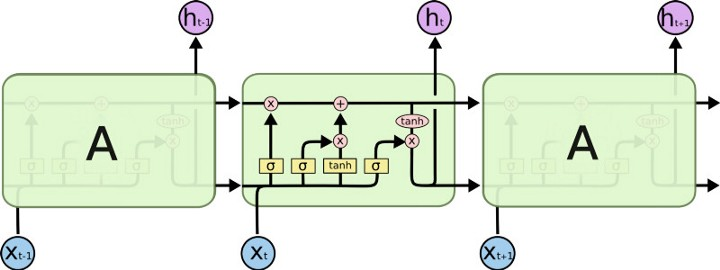

In [41]:
Image(filename='local/imgs/LSTM2.jpeg', width=1200)

In [42]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error

In [43]:
# First, we get the data
dataset = pd.read_csv('local/data/KO_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,20.40,20.50,20.18,20.45,13640800,KO
2006-01-04,20.50,20.54,20.33,20.41,19993200,KO
2006-01-05,20.36,20.56,20.29,20.51,16613400,KO
2006-01-06,20.53,20.78,20.43,20.70,17122800,KO
2006-01-09,20.74,20.84,20.62,20.80,13819800,KO


In [44]:
# Checking for missing values
training_set = dataset[:'2015'].iloc[:,1:2].values
test_set = dataset['2016':].iloc[:,1:2].values
test_set[np.isnan(test_set)] = dataset['High'].max()

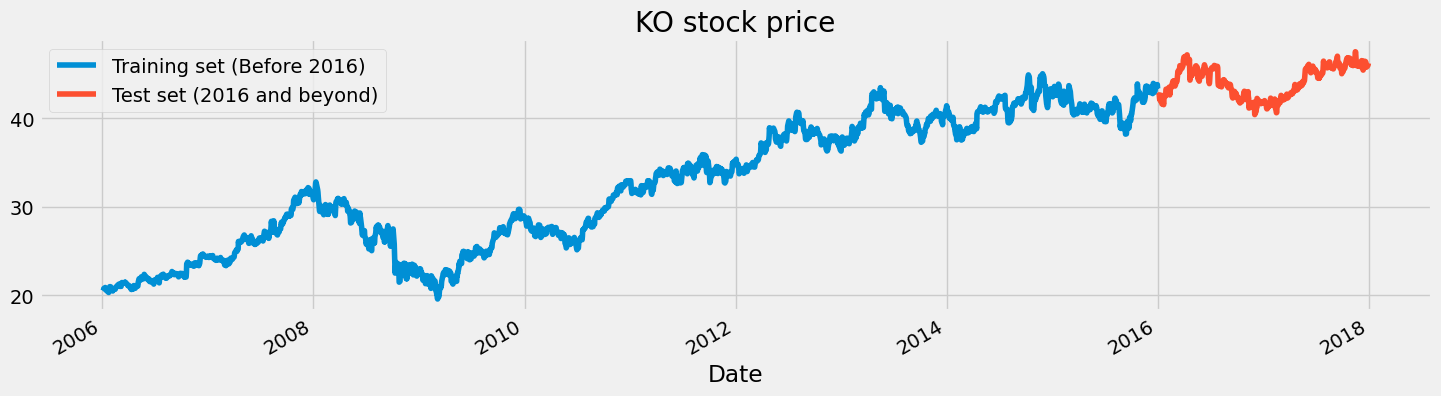

In [45]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2015'].plot(figsize=(16,4),legend=True)
dataset["High"]['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
plt.title('KO stock price')
plt.show()

In [46]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [47]:
from local.lib.DataPreparationRNN import create_dataset
look_back = 10
X_train, y_train = create_dataset(training_set_scaled, look_back)
print(X_train.shape)
print(y_train.shape)

(2507, 10)
(2507,)


In [48]:
# The RNN architecture
model = Sequential()
# First RNN layer with Dropout regularisation
model.add(SimpleRNN(units=50,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

/home/proci/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Let's remember what a RNN can do:

In [50]:


# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0691
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 16/50
79/79 ━━━━━━━━━━━━

In [51]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - look_back:].values
inputs[np.isnan(inputs)] = dataset['High'].max()
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(513, 1)

In [52]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


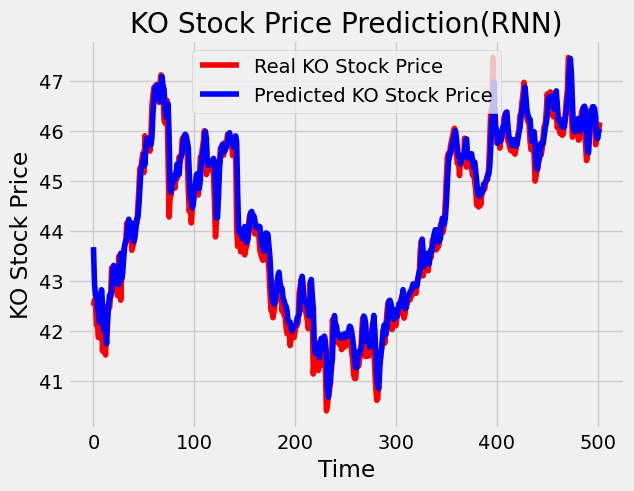

In [53]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(RNN)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [54]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.3401024011636967.


Ahora usando una LSTM:

In [55]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

/home/proci/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
regressor.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1221
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 16/50
79/79 ━━━━━━━━━━━

In [58]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


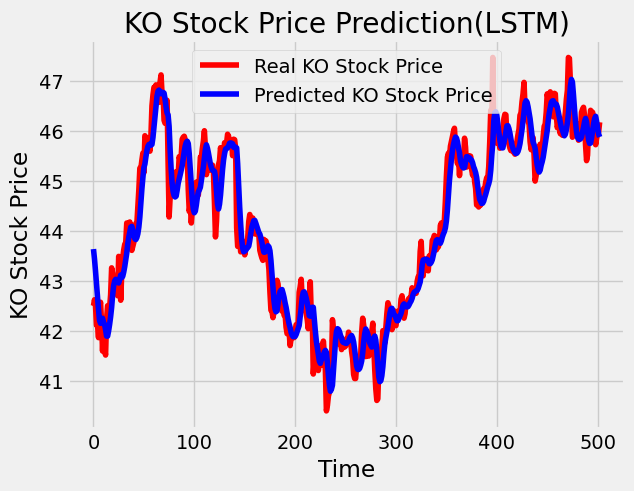

In [59]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(LSTM)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [60]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.4423201504686051.


# Gated Recurrent Units

La unidad GRU no tiene que utilizar una unidad de memoria para controlar el flujo de información como la unidad LSTM. Puede hacer uso directamente de todos los estados ocultos sin ningún control. Las GRU tienen menos parámetros y, por lo tanto, pueden entrenarse un poco más rápido o necesitar menos datos para generalizar. Pero, con una gran cantidad de datos, los LSTM con mayor expresividad pueden generar mejores resultados. [Fuente](https://www.kaggle.com/honeysingh/intro-to-recurrent-neural-networks-lstm-gru/notebook)

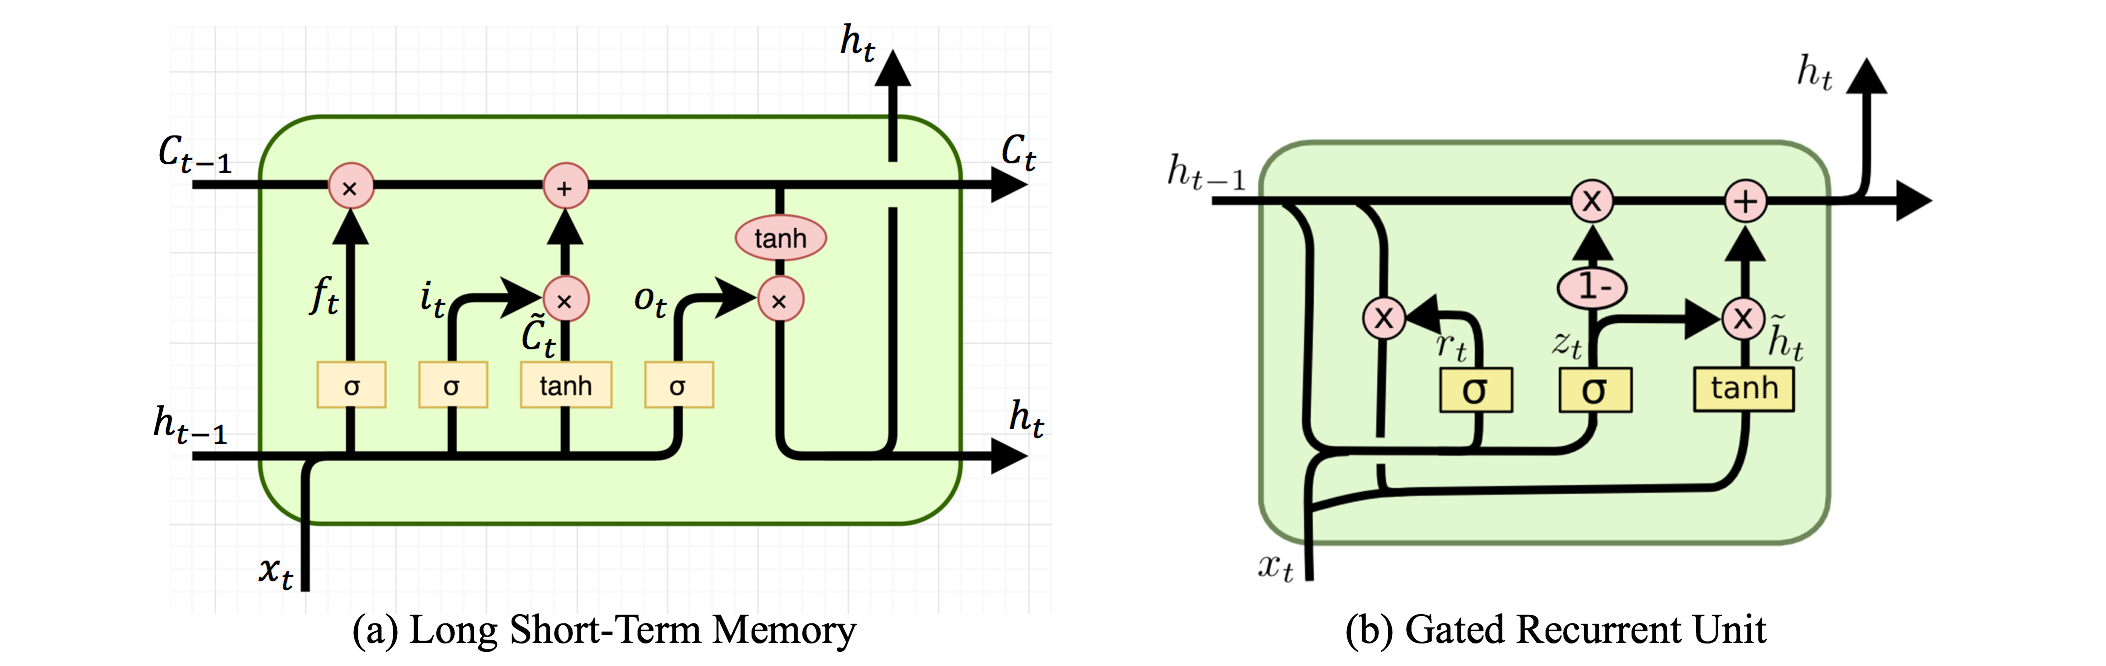

In [61]:
Image(filename='local/imgs/lstmandgru.png', width=1200)

[Source](https://isaacchanghau.github.io/post/lstm-gru-formula/)

$$z_t = \sigma(x_t U^z + h_{t-1} V^z)$$

$$r_t = \sigma(x_t U^r + h_{t-1} V^r)$$

$$\tilde{h}_t = \tanh(x_t U^h +(r_t h^{t−1}) W^h)$$

$$ h_t = (1-z_t)h_{t-1} + z_t \tilde{h}_t$$

Aquí $r$ es una puerta de reinicio y $z$ es una puerta de actualización. Intuitivamente, la puerta de reinicio determina cómo combinar la nueva entrada con la memoria anterior, y la puerta de actualización define cuánta memoria anterior se conserva. Si configura el reinicio en todos los 1 y actualiza la puerta en todos los 0, llegará al modelo RNN básico.

In [62]:
# The GRU architecture
regressor2 = Sequential()
# First GRU layer with Dropout regularisation
regressor2.add(GRU(units=50, input_shape=(X_train.shape[1],1)))
regressor2.add(Dropout(0.3))
# The output layer
regressor2.add(Dense(units=1))

/home/proci/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
regressor2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compiling the RNN
regressor2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor2.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0800
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 16/50
79/79 ━━━━━━━━━━━━

**Note** that the every epoch runs a little bit faster than in the LSTM model.

In [65]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


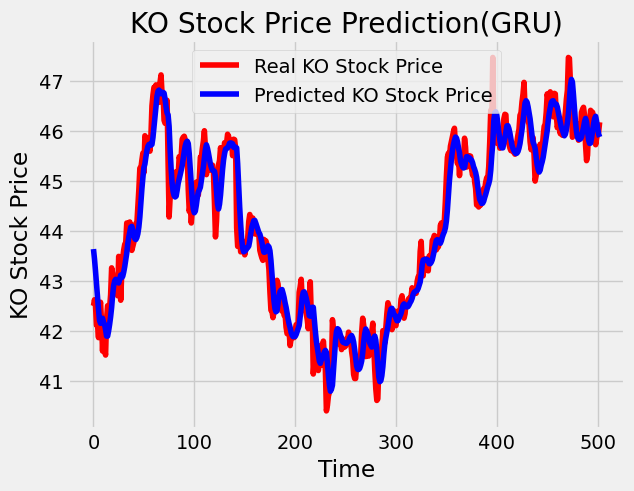

In [66]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [67]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.4423201504686051.


Interesting readings:

 - Understanding LSTM Networks. http://colah.github.io/posts/2015-08-Understanding-LSTMs/